In [ ]:
!pip install --upgrade langchain-openai langgraph faiss-cpu graphviz

In [ ]:
# Multi-Agent LangGraph (Updated for LangGraph >=0.4)

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.agents import Tool, initialize_agent, AgentType
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.schema import Document
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import faiss

# Set your OpenAI key
from google.colab import userdata
OPENAI_API_KEY = userdata.get("OpenAI-key")


# Set API key
# os.environ["OPENAI_API_KEY"] = "your-openai-key"

# LLM and embedding setup
# Initialize LLM with API Key "babbage-002"
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_API_KEY)

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

# Simulated RAG memory with FAISS
documents = [
    Document(page_content="Climate change affects the economy by disrupting agriculture and increasing natural disasters."),
    Document(page_content="AI agents can be used to automate workflows and decision making."),
]
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever()
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

# Define tools
search_tool = Tool(
    name="Search",
    func=lambda q: rag_chain.run(q),
    description="Use for factual questions about documents or knowledge base."
)
summarize_tool = Tool(
    name="Summarize",
    func=lambda text: llm.predict(f"Summarize this: {text}"),
    description="Summarizes long text into concise points."
)

# Agent initializers
def research_agent():
    return initialize_agent(
        tools=[search_tool],
        llm=llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True
    )

def analysis_agent():
    return initialize_agent(
        tools=[summarize_tool],
        llm=llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True
    )

# Define state
class AgentState(TypedDict):
    question: str
    route: Annotated[str, "route"]
    research: str
    summary: str

# Router node
def router_node(state: AgentState):
    question = state["question"]
    if any(kw in question.lower() for kw in ["summarize", "analyze"]):
        state["route"] = "analyze"
    else:
        state["route"] = "research"
    return state

# Agent nodes
def node_research(state: AgentState):
    agent = research_agent()
    result = agent.run(state["question"])
    state["research"] = result
    return state

def node_analysis(state: AgentState):
    agent = analysis_agent()
    target = state.get("research") or state["question"]
    result = agent.run(f"Summarize or analyze: {target}")
    state["summary"] = result
    return state

def node_output(state: AgentState):
    print("\n--- Final Output ---")
    print(state.get("summary") or state.get("research"))
    return state

# Define LangGraph
builder = StateGraph(AgentState)
builder.add_node("router", router_node)
builder.add_node("research_node", node_research)
builder.add_node("analyze_node", node_analysis)
builder.add_node("output_node", node_output)


builder.set_entry_point("router")

builder.add_conditional_edges(
    "router",
    lambda state: state["route"],
    {
        "research": "research_node",
        "analyze": "analyze_node"
    }
)
builder.add_edge("research_node", "analyze_node")
builder.add_edge("analyze_node", "output_node")

builder.set_finish_point("output_node")

graph = builder.compile()

# Run
if __name__ == "__main__":
    question = input("Ask a question: ")
    initial_state = {"question": question}
    graph.invoke(initial_state)


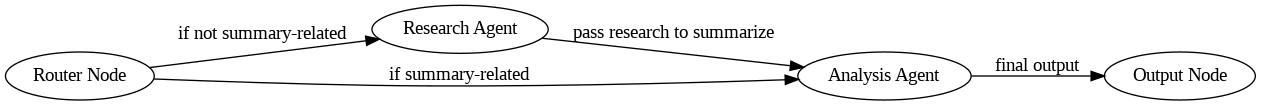

In [ ]:


import graphviz
from IPython.display import Image, display

# Create a diagram of the LangGraph structure
dot = graphviz.Digraph(format='png')
dot.attr(rankdir='LR')

# Define nodes
dot.node('router', 'Router Node')
dot.node('research', 'Research Agent')
dot.node('analyze', 'Analysis Agent')
dot.node('output', 'Output Node')

# Define edges
dot.edge('router', 'research', label='if not summary-related')
dot.edge('router', 'analyze', label='if summary-related')
dot.edge('research', 'analyze', label='pass research to summarize')
dot.edge('analyze', 'output', label='final output')

# Render and display the graph inline
filename = dot.render('langgraph_structure')
display(Image(filename))